## MMA 860 Team Project: Predicting Housing Prices

Team Istanbul

In [132]:
# %pip install openpyxl
# %matplotlib inline
# %pip install statsmodels
# %pip install scikit-learn seaborn
# %pip install jupyter_contrib_nbextensions
# %pip install --upgrade scikit-learn

In [133]:
import os

import pandas as pd
import numpy as np

import statsmodels.imputation.mice as mice
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error, mean_squared_error

from patsy import dmatrices
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns

In [134]:
#Converting data source to dataframes
file_path_test  = "test.csv"
file_path_train = "train.csv"

df_test  = pd.read_csv(file_path_test, index_col="Id")
df_train = pd.read_csv(file_path_train, index_col="Id")

In [135]:
df_train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Project Code

### Data Cleaning
1. Check for nulls
2. Check of data-type inconsistencies
3. Check for duplicate rows

In [136]:
#checking for datatype
print(df_train.dtypes)

#Print column with inconsistent datatypes (if any)
for col in df_train.columns:
    unique_types = set(df_train[col].dropna().apply(type)) 
    if len(unique_types) > 1:
        print(f"Column '{col}' has inconsistent data types: {unique_types}")

MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
Length: 80, dtype: object


In [137]:
df_train.shape

(1460, 80)

In [138]:
#check for duplicates
duplicate_count = df_train.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")

Number of duplicate rows: 0


In [139]:
cols = df_train.columns.tolist()

#Checking column names; removing spaces from name
for col in cols:
    if ' ' in col:
        new_col = col.replace(' ', '')
        print(f"Removing space in {col}: new name {new_col}")
        
        df_train.rename(columns={col: new_col}, inplace=True)

In [140]:
#Checking if any columns are completely empty
for col in cols:
    if df_train[col].astype(str).str.strip().eq('').all():
        print(f"Column {col} is empty. To be deleted...")

<h5 style="color: blue;">Numeric Columns Data Cleaning</h5>

1. Test numeric columns
2. Clean and add data wherever necessary

In [141]:
#Checking for nulls in columns (grouped by datatype)

#Initializing lists to store column names with null values
col_num_nulls = []
col_obj_nulls = []

for dtype in sorted(df_train.dtypes.unique(), key=str):  
    
    # Select columns of the current data type and sort by null count
    cols = [col for col in df_train.columns if df_train[col].dtypes == dtype]
    sorted_cols = sorted(cols, key=lambda col: df_train[col].isnull().sum(), reverse=True)
    
    if df_train[col].isnull().sum() == 0:
        print(f"------------- {dtype} -------------")
    
    # Print columns and their respective null counts
    for col in sorted_cols:
        null_count = df_train[col].isnull().sum()
        if null_count > 0:
            print(f"{col} : {null_count}")
            
            #Storing column names in the lists
            if dtype == 'object':
                col_obj_nulls.append(col)
            else:
                col_num_nulls.append(col)

    print("\n")

------------- float64 -------------
LotFrontage : 259
GarageYrBlt : 81
MasVnrArea : 8




------------- object -------------
PoolQC : 1453
MiscFeature : 1406
Alley : 1369
Fence : 1179
FireplaceQu : 690
GarageType : 81
GarageFinish : 81
GarageQual : 81
GarageCond : 81
BsmtExposure : 38
BsmtFinType2 : 38
BsmtQual : 37
BsmtCond : 37
BsmtFinType1 : 37
MasVnrType : 8
Electrical : 1




<h6 style="color: #ff5733;">Null Count Findings:</h6>

1. No spaces found in column names. 
2. There are no columns that are completely empty. 
3. There are no duplicate rows.

**Float Data Type**
1. There are 3 float type columns with null values. 
2. The maximum number of null values in a column are 259. 
3. All null values can be populated using multiple imputations

**Object Data Type**
1. There are 22 object type columns with null values. 
2. There are 4 columns that are more than 45% empty (i.e. less than 55% populated), therefore these columns must be deleted to prevent model skewing: <br>
&nbsp;&nbsp;&nbsp;&nbsp;<table>
    <tr>
        <th>Column</th>
        <th>Null Values</th>
        <th>Percent Empty</th>
    </tr>
    <tr>
        <td>PoolQC</td>
        <td>1453</td>
        <td>99.5%</td>
    </tr>
    <tr>
        <td>MiscFeature</td>
        <td>1406</td>
        <td>96.3%</td>
    </tr>
    <tr>
        <td>Alley</td>
        <td>1369</td>
        <td>93.8%</td>
    </tr>
    <tr>
        <td>Fence</td>
        <td>1179</td>
        <td>80.7%</td>
    </tr>
    <tr>
        <td>FireplaceQu</td>
        <td>690</td>
        <td>47.3%</td>
    </tr>
</table>
<br>3. For the remainder columns, 'None' will replace any empty values in the column. Using 'None' implies that the feature doesn't apply to that record. Adding another value could incorrectly skew the weight & outcome of that column. After adding 'None', <span style="background-color: yellow;"> we need to ensure the value/area of the corresponding feature is 0 (as imputation could add a non-zero value to it.</span> 

In [142]:
#Running multiple imputations on numeric columns feat
df_numeric = df_train.loc[:, col_num_nulls]
imp        = mice.MICEData(df_numeric)
imp.next_sample()

imputed_data = imp.data

# Update df_train with the imputed values
for col in df_numeric.columns:
    df_train[col] = df_train[col].where(df_train[col].notnull(), imputed_data[col])

In [143]:
#Replacing null values in object columns with 'None'
for col in col_obj_nulls:
    df_train[col] = df_train[col].fillna('None')

#Dropping columns that more than 45% empty 
df_train = df_train.drop(['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu'], axis = 1)

In [144]:
#Checking no null values remain
cols = df_train.columns.tolist()

for col in cols:
    null_count = df_train[col].isnull().sum()
    if null_count > 0:
        print(f"{col} : {null_count}")

In [145]:
#Ensuring the value/area of the corresponding feature is 0

#If BsmtQual == None then TotalBsmtSF and TotalBsmtSF should be 0
df_train.loc[df_train['BsmtQual'].isnull(), ['TotalBsmtSF', 'BsmtUnfSF']] = 0

#If BsmtFinType2 == None then BsmtFinSF2 should be 0
df_train.loc[df_train['BsmtFinType2'].isnull(), ['BsmtFinSF2']] = 0

#If BsmtFinType1 == None then BsmtFinSF1 should be 0
df_train.loc[df_train['BsmtFinType1'].isnull(), ['BsmtFinSF1']] = 0

In [146]:
#Checking the above logic is being followed (value/area when feature doesn't exist should be 0)

logic_violated = False

#Check for basement quality vs total basement area & unfinished basement area
if not df_train.loc[df_train['BsmtQual'].isnull() & 
                    ((df_train['TotalBsmtSF'] != 0) | (df_train['BsmtUnfSF'] != 0))].empty:
    print("Rows violating BsmtQual logic:")
    print(df_train.loc[df_train['BsmtQual'].isnull() & 
                       ((df_train['TotalBsmtSF'] != 0) | (df_train['BsmtUnfSF'] != 0))])

#Check for first basement quality and first basement area
if not df_train.loc[df_train['BsmtFinType1'].isnull() & 
                (df_train['BsmtFinSF1'] != 0)].empty:
    print("\nRows violating BsmtFinType1 logic:")
    print(df_train.loc[df_train['BsmtFinType1'].isnull() & 
                       (df_train['BsmtFinSF1'] != 0)])

#Check for second basement quality and second basement are
if not df_train.loc[df_train['BsmtFinType2'].isnull() & 
                    (df_train['BsmtFinSF2'] != 0)].empty:
    print("\nRows violating BsmtFinType2 logic:")
    print(df_train.loc[df_train['BsmtFinType2'].isnull() & 
                       (df_train['BsmtFinSF2'] != 0)])

if not logic_violated:
    print("No logic violated.")


No logic violated.


### Exploratory Data Analysis
1. Statistical analysis of variables
2. Check for outliers
3. Test for biases after imputations

<h5 style="color: blue;">Numeric Columns Outlier Analysis</h5>

Check for outliers for all numeric data type columns

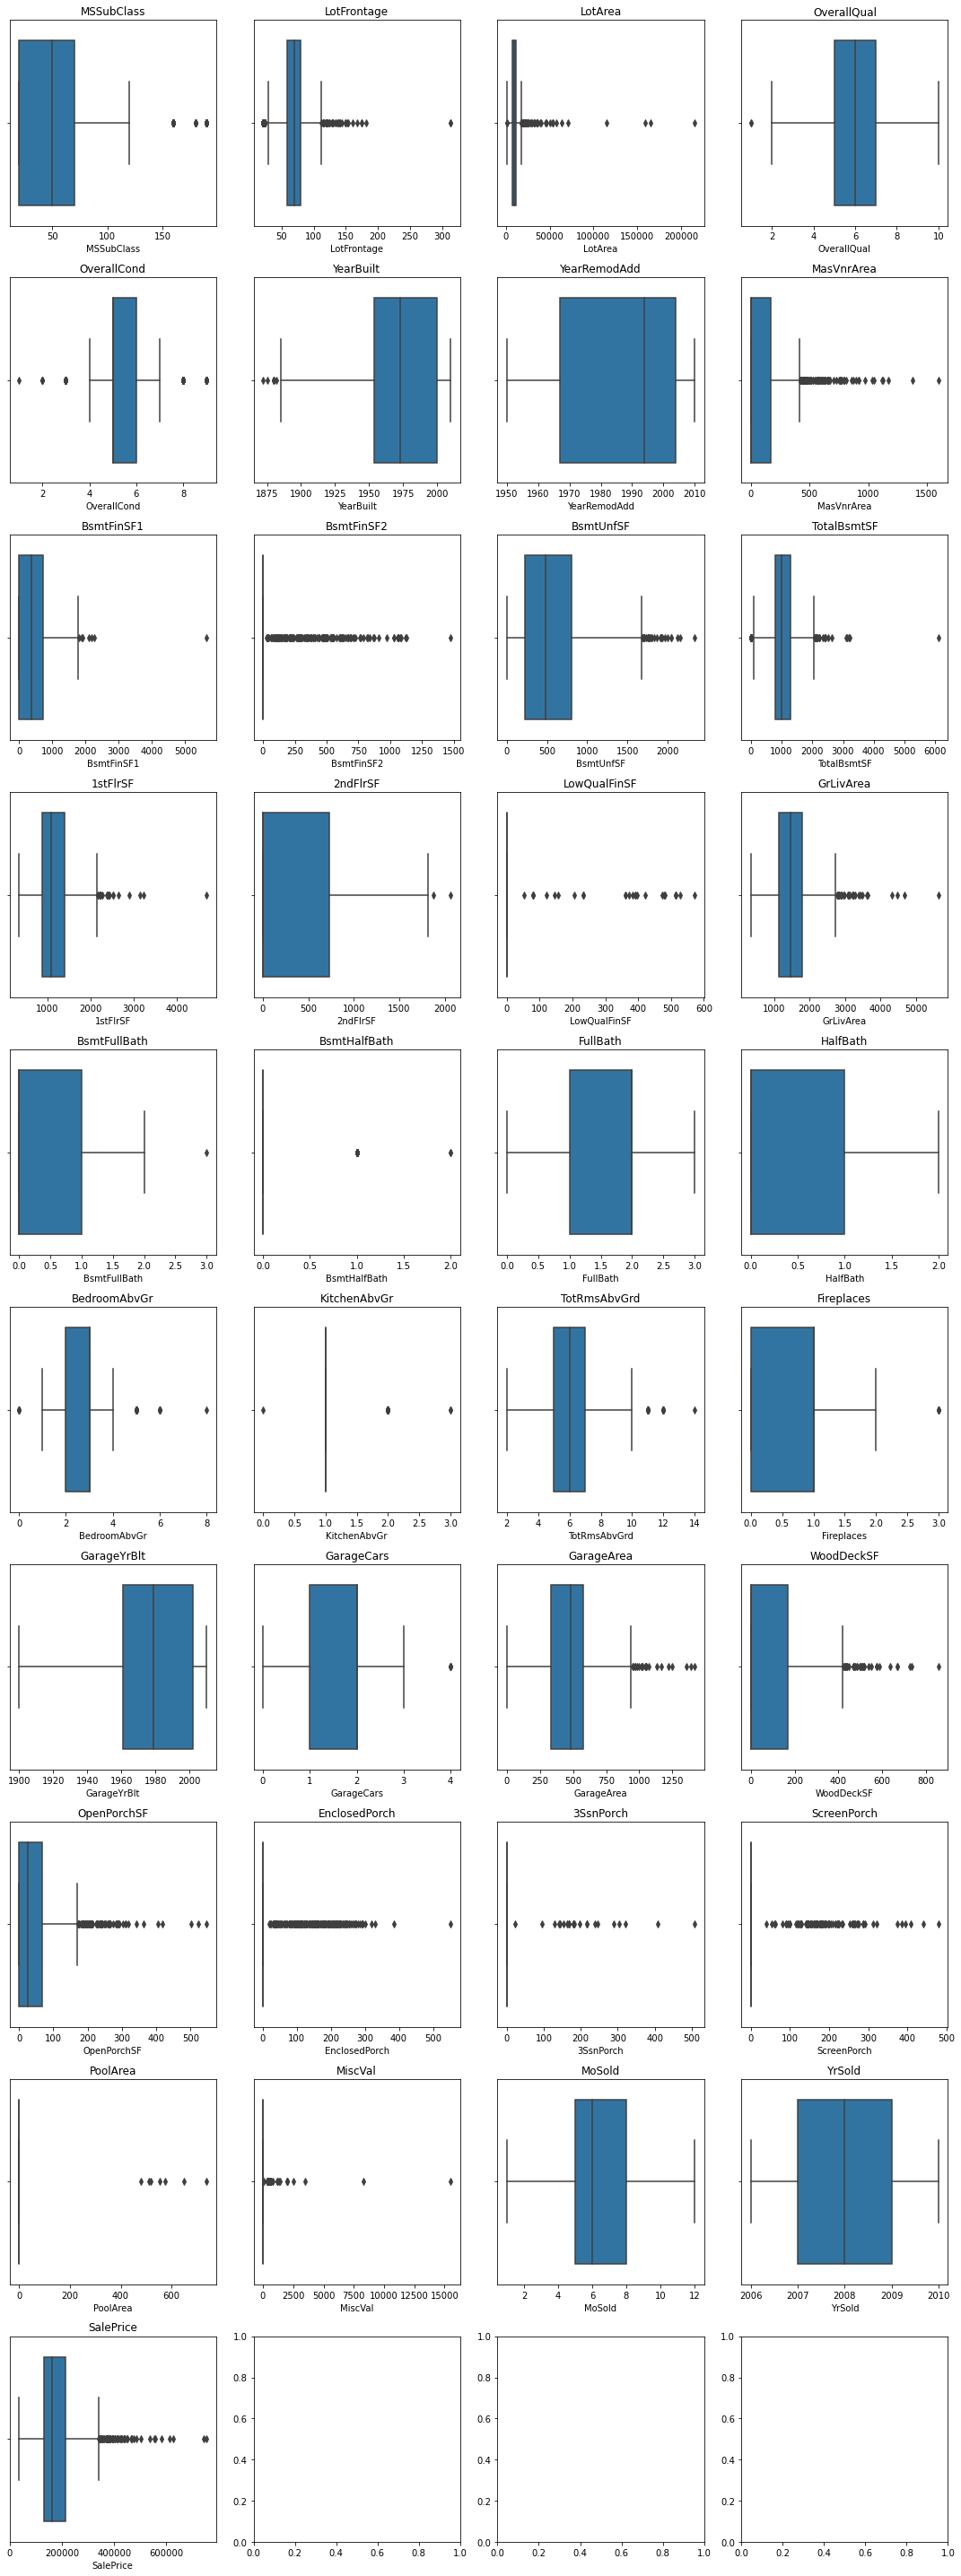

In [147]:
num_cols = df_train.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Define the number of plots per row
plots_per_row = 4
num_cols_count = len(num_cols)
rows = (num_cols_count // plots_per_row) + (num_cols_count % plots_per_row > 0) 

# Create subplots
fig, axes = plt.subplots(rows, plots_per_row, figsize=(15, rows * 4))
axes = axes.flatten()  # Flatten in case of multiple rows

# Box plot for each numeric column
for i, col in enumerate(num_cols):
    sns.boxplot(x=df_train[col], ax=axes[i])
    axes[i].set_title(f'{col}')
plt.tight_layout()
plt.show()

<h6 style="color: #ff5733;">Outlier Findings:</h6>

A lot numeric columns contain outliers (as can be seen in the box and whisker plots)
1. **Area columns:** For features related to area, the value of 0 is the most frequent value, representing unfinished or non-existent features. 
2. **Condition columns:** These columns contain ratings for various aspects of the house, such as its condition.
3. **Age columns:** These columns can be combined, the difference of Year Sold and Year Built can be used to create a new column Age Sold


Columns to be removed:

| Column | Logic |
| :--- | :--- |
| MasVnrArea | 0s are overrepresented and can skew the data|
| KitchenAbvGr| Only has one value |
| PoolArea| 0s overrepresented |
| EnclosedPorch <br> 3SsnPorch <br> ScreenPorch| 0s overrepresented all other points are statistically outliers |


In [148]:
#Combining Year Sold and Year Built columns into Age Sold
df_train['AgeSold'] = df_train['YrSold'] - df_train['YearBuilt']

df_train = df_train.drop(columns = ['YrSold', 'YearBuilt', 'KitchenAbvGr', 'PoolArea', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch' ])

In [149]:
df_train = df_train.drop(columns = ['MasVnrArea'])

<h5 style="color: blue;">Categorical Columns Data Exploration</h5>

1. Test categorical columns
2. Clean and add/remove data wherever necessary

In [150]:
#Checking for distinct values in all colums of datatype 'object'
cat_cols = df_train.select_dtypes(include=['object']).columns.tolist()

# 
for col in cat_cols:
    print(f"In column {col}: ")
    print(df_train[col].unique())
    print("\n")

In column MSZoning: 
['RL' 'RM' 'C (all)' 'FV' 'RH']


In column Street: 
['Pave' 'Grvl']


In column LotShape: 
['Reg' 'IR1' 'IR2' 'IR3']


In column LandContour: 
['Lvl' 'Bnk' 'Low' 'HLS']


In column Utilities: 
['AllPub' 'NoSeWa']


In column LotConfig: 
['Inside' 'FR2' 'Corner' 'CulDSac' 'FR3']


In column LandSlope: 
['Gtl' 'Mod' 'Sev']


In column Neighborhood: 
['CollgCr' 'Veenker' 'Crawfor' 'NoRidge' 'Mitchel' 'Somerst' 'NWAmes'
 'OldTown' 'BrkSide' 'Sawyer' 'NridgHt' 'NAmes' 'SawyerW' 'IDOTRR'
 'MeadowV' 'Edwards' 'Timber' 'Gilbert' 'StoneBr' 'ClearCr' 'NPkVill'
 'Blmngtn' 'BrDale' 'SWISU' 'Blueste']


In column Condition1: 
['Norm' 'Feedr' 'PosN' 'Artery' 'RRAe' 'RRNn' 'RRAn' 'PosA' 'RRNe']


In column Condition2: 
['Norm' 'Artery' 'RRNn' 'Feedr' 'PosN' 'PosA' 'RRAn' 'RRAe']


In column BldgType: 
['1Fam' '2fmCon' 'Duplex' 'TwnhsE' 'Twnhs']


In column HouseStyle: 
['2Story' '1Story' '1.5Fin' '1.5Unf' 'SFoyer' 'SLvl' '2.5Unf' '2.5Fin']


In column RoofStyle: 
['Gable' 'Hip' 

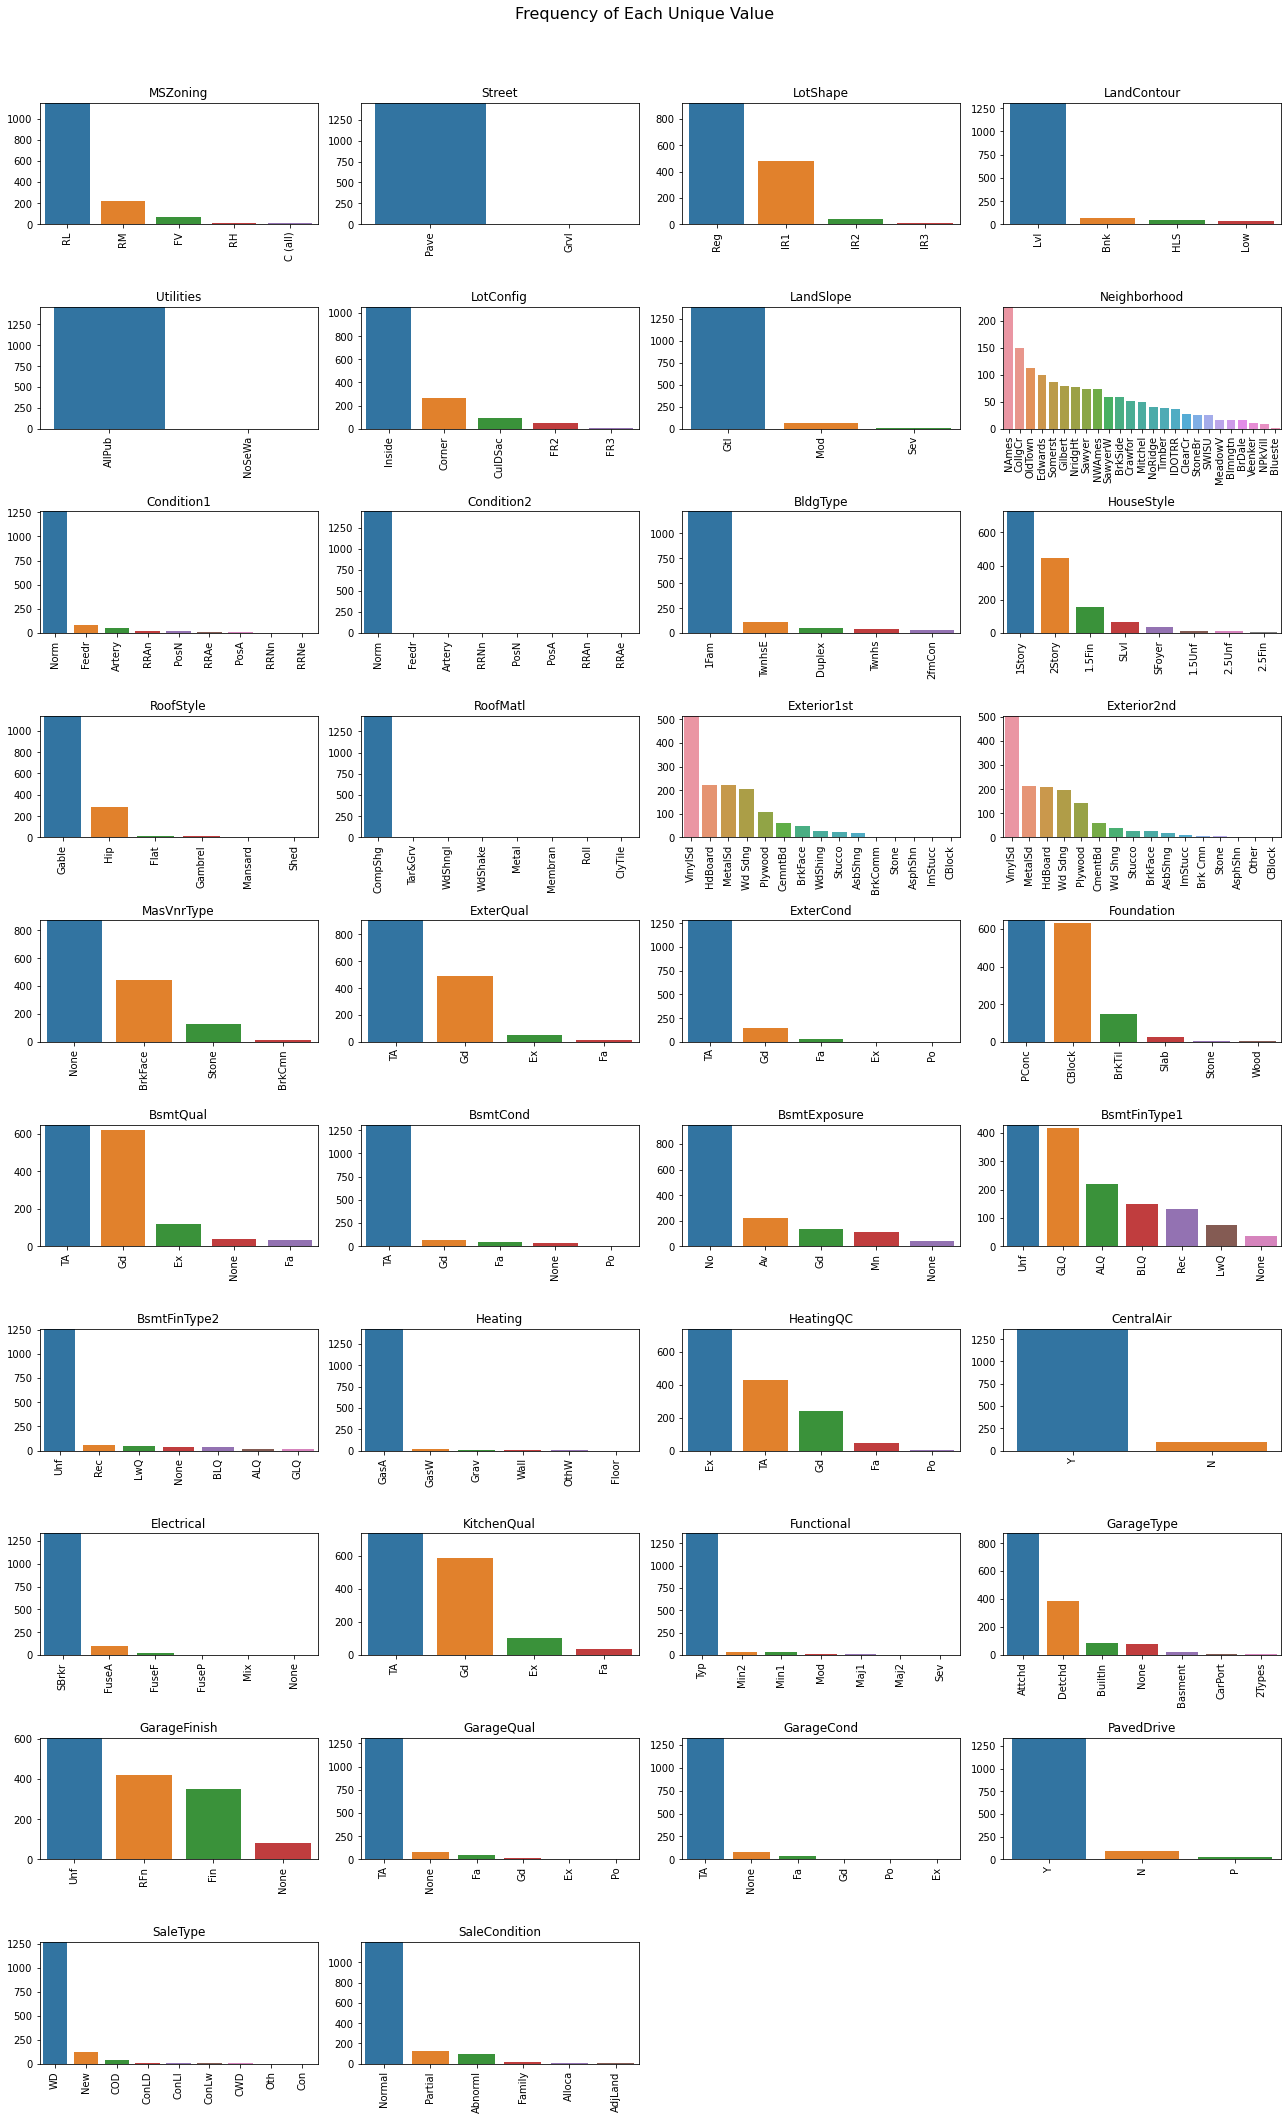

In [151]:
#Plotting the frequency of each unique value
cols = df_train.select_dtypes(include=['object']).columns 
num_cols = len(cols)
num_rows = (num_cols // 4) + (num_cols % 4 > 0)

plt.figure(figsize=(18, num_rows * 3))  
plt.suptitle('Frequency of Each Unique Value', fontsize=16)

index = 1

for index, col in enumerate(cols, start=1):
    plt.subplot(num_rows, 4, index)
    plt.xticks(rotation=90)
    plt.title(col)

    count = df_train[col].value_counts()
    
    sns.barplot(x = count.index, y = count.values)
    
    plt.ylim(0, count.max())
    index +=1
    

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [152]:
#From the graphs, testihng counts for columns that appear skewed in value distribution
test_cols = ['Utilities', 'Street', 'Condition2', 'RoofMatl', 'GarageCond', 'Functional', 'Heating', 'Electrical']

for col in test_cols:
    print(f"Column {col} values:")
    print(df_train[col].value_counts())
    print("\n")

Column Utilities values:
AllPub    1459
NoSeWa       1
Name: Utilities, dtype: int64


Column Street values:
Pave    1454
Grvl       6
Name: Street, dtype: int64


Column Condition2 values:
Norm      1445
Feedr        6
Artery       2
RRNn         2
PosN         2
PosA         1
RRAn         1
RRAe         1
Name: Condition2, dtype: int64


Column RoofMatl values:
CompShg    1434
Tar&Grv      11
WdShngl       6
WdShake       5
Metal         1
Membran       1
Roll          1
ClyTile       1
Name: RoofMatl, dtype: int64


Column GarageCond values:
TA      1326
None      81
Fa        35
Gd         9
Po         7
Ex         2
Name: GarageCond, dtype: int64


Column Functional values:
Typ     1360
Min2      34
Min1      31
Mod       15
Maj1      14
Maj2       5
Sev        1
Name: Functional, dtype: int64


Column Heating values:
GasA     1428
GasW       18
Grav        7
Wall        4
OthW        2
Floor       1
Name: Heating, dtype: int64


Column Electrical values:
SBrkr    1334
FuseA     

<h6 style="color: #ff5733;">Unique Value & Frequency Findings:</h6>

Based on the graphs and the 4 columns tested above, one value in each column is over represented. Therefore, in the overall regression model, these columns wouldn't make much of a difference. However, a balance must be maintained between simplifying the model while retaining sensitivity to variance

| Column | Action | Logic |
| :--- | :--- | :--- |
| Utilities <br> Street | <span style="color: red;">Remove</span> | Column has no variability and will only introduce noise. |
| Condition2 <br> RoofMtl <br> Functional <br> Heating| <span style="color: red;">Remove</span> | One value is overrepresented, it's important to drop it for model sensitivity |

This approach balances model efficacy and simplicity

In [153]:
#Dropping columns based on data dictionary description and from unique value frequency findings
df_train = df_train.drop(columns=test_cols)
df_train = df_train.drop(columns=['MiscVal', 'MoSold', 'SaleType', 'SaleCondition'])

<h6 style="color: #ff5733;">Data Dictionary Findings:</h6>

1. **MiscVal:** This feature lacks sufficient description and domain context, making it difficult to interpret or engineer meaningfully. 

2. **MoSold:** We are already considering Year Sold and using Year Built to calculate house age. Month Sold adds minimal additional predictive power and can be omitted.

3. **SaleType:** While it might have some effect on price, it often reflects situational or financial conditions that may not generalize well in prediction models.
4. **SaleCondition:** We're building a model to predict market value, not transaction price, therefore this is not needed 

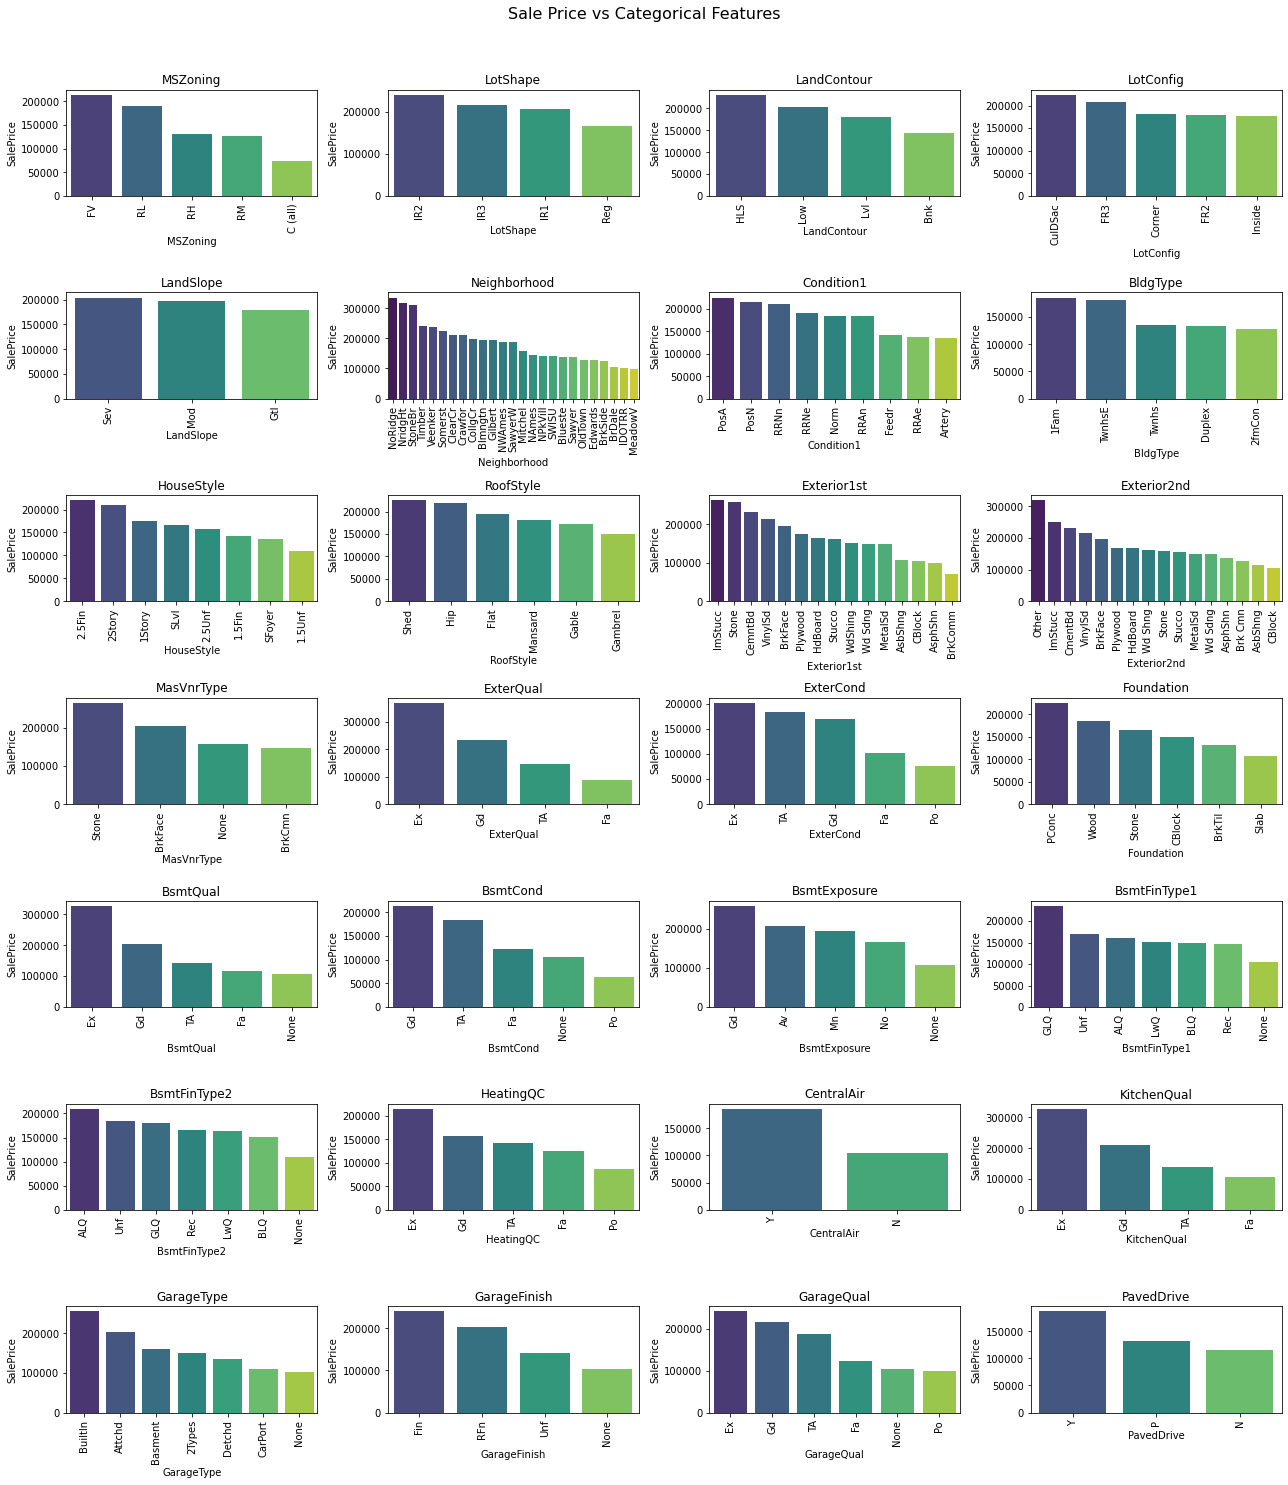

In [154]:
#Plotting the frequency of each unique value
cols = df_train.select_dtypes(include=['object']).columns 
num_cols = len(cols)
num_rows = (num_cols // 4) + (num_cols % 4 > 0)

plt.figure(figsize=(18, num_rows * 3))  
plt.suptitle('Sale Price vs Categorical Features', fontsize=16)

index = 1

for index, col in enumerate(cols, start=1):
    plt.subplot(num_rows, 4, index)
    plt.xticks(rotation=90)
    plt.title(col)

    avg_price = df_train.groupby(col)['SalePrice'].mean().sort_values(ascending = False).reset_index()
    
    sns.barplot(x=col, y='SalePrice', data=avg_price, palette='viridis')
    

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

<h6 style="color: #ff5733;">Categorical Data vs Sale Price Findings:</h6>

Based on the graphs the following columns will be dropped due to low variance in Sale Price from the unique values in those columns

1. BsmtFinType2
2. GarageQual
3. Condition1
4. LandSlope
5. RoofStyle
6. LandContour
7. LotConfig
8. BsmtFinType1
9. LotShape
10. ExterCond
11. PavedDrive

This approach balances model efficacy and simplicity

In [155]:
#Dropping columns based on categorical vs sale price analysis
df_train = df_train.drop(columns=['GarageQual', 'PavedDrive','ExterCond', 'LotShape', 'BsmtFinType1', 'BsmtFinType2', 'Condition1', 'LandSlope', 'RoofStyle', 'LandContour', 'LotConfig'])

<h5 style="color: blue;">Correlation Testing</h5>

1. Test numeric columns against the Sale Price to see how strongly they're related
2. Remove columns with low correlation

In [156]:
# Correlation matrix for Numeric columns
correlation_matrix = df_train.select_dtypes(include=['float64', 'int64']).corr()

# Correlation with SalePrice, sorted
print(correlation_matrix['SalePrice'].sort_values(ascending=False))

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearRemodAdd    0.507101
Fireplaces      0.466929
GarageYrBlt     0.463055
BsmtFinSF1      0.386420
WoodDeckSF      0.324413
2ndFlrSF        0.319334
OpenPorchSF     0.315856
LotFrontage     0.301294
HalfBath        0.284108
LotArea         0.263843
BsmtFullBath    0.227122
BsmtUnfSF       0.214479
BedroomAbvGr    0.168213
BsmtFinSF2     -0.011378
BsmtHalfBath   -0.016844
LowQualFinSF   -0.025606
OverallCond    -0.077856
MSSubClass     -0.084284
AgeSold        -0.523350
Name: SalePrice, dtype: float64


In [157]:
#Dropping low correlation columns
corr_target = correlation_matrix['SalePrice']
corr_drop   = correlation_matrix[(corr_target > -0.1) & (corr_target < 0.1)].index.tolist()

print("Numerical columns dropped:\n")
for col in corr_drop:
    print(col)

df_train = df_train.drop(columns = corr_drop)

Numerical columns dropped:

MSSubClass
OverallCond
BsmtFinSF2
LowQualFinSF
BsmtHalfBath


<h6 style="color: #ff5733;">Correlation Findings:</h6>

Housing prices in the dataset are right-skewed and spread widely, ranging from $34,900 to $755,000, with an average around $181K. This wide range reflects the heterogeneity in home size, location, condition, and age.

**Key findings:**

1. OverallQual (0.79) and GrLivArea (0.71) show the strongest positive correlation with sale price.

2. Garage features also matter: GarageCars (0.64) and GarageArea (0.62) boost price.

3. Other moderately important features include TotalBsmtSF, 1stFlrSF, Fireplaces, and FullBath (correlations from 0.45–0.61).

4. These findings match buyer expectations — more space, better finishes, and modern upgrades = higher value.

5. Following columsn have been dropped due to very low correlation with Sale Price (-0.02 < Correlation < 0.02)

- MSSubClass
- OverallCond
- BsmtFinSF2
- LowQualFinSF
- BsmtHalfBath

***Note:*** Categorical variables like Neighborhood, ExterQual, or HouseStyle were not included in the correlation matrix, as they require one-hot encoding. These will be handled during the feature engineering phase.

The EDA step focused on uncovering general patterns, which will inform feature selection and multicollinearity checks during modeling.

### Feature Engineering
1. Dummy variables/One Hot Encoding
2. Test variable significance
3. Collinearity analysis
4. Dimension reduction

<h5 style="color: blue;">GrLivArea and Neighborhood Analysis</h5>

1. Test Sale Price across neighbourhoods and living areas
2. Test for collinearity strength

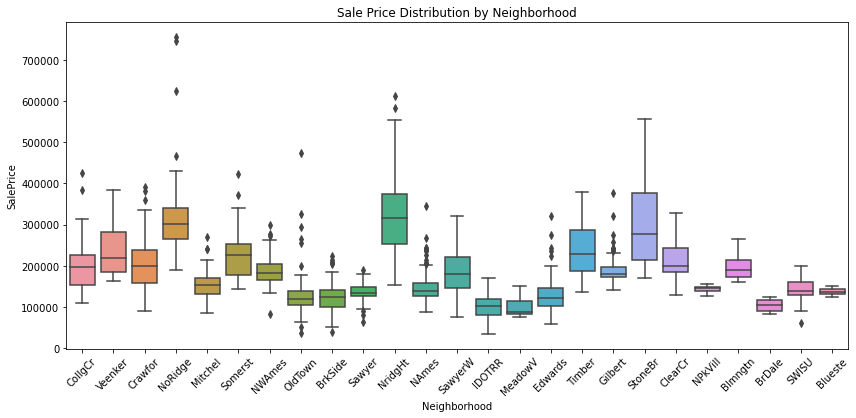

In [158]:
# Boxplot of SalePrice across neighborhoods
plt.figure(figsize=(14, 6))
sns.boxplot(x='Neighborhood', y='SalePrice', data=df_train)
plt.xticks(rotation=45)
plt.title('Sale Price Distribution by Neighborhood')
plt.show()

In [159]:
# Interaction term between GrLivArea and Neighborhood
model = ols('SalePrice ~ GrLivArea * C(Neighborhood)', data=df_train).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.798
Model:                            OLS   Adj. R-squared:                  0.791
Method:                 Least Squares   F-statistic:                     114.0
Date:                Thu, 10 Apr 2025   Prob (F-statistic):               0.00
Time:                        20:25:13   Log-Likelihood:                -17375.
No. Observations:                1460   AIC:                         3.485e+04
Df Residuals:                    1410   BIC:                         3.511e+04
Df Model:                          49                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


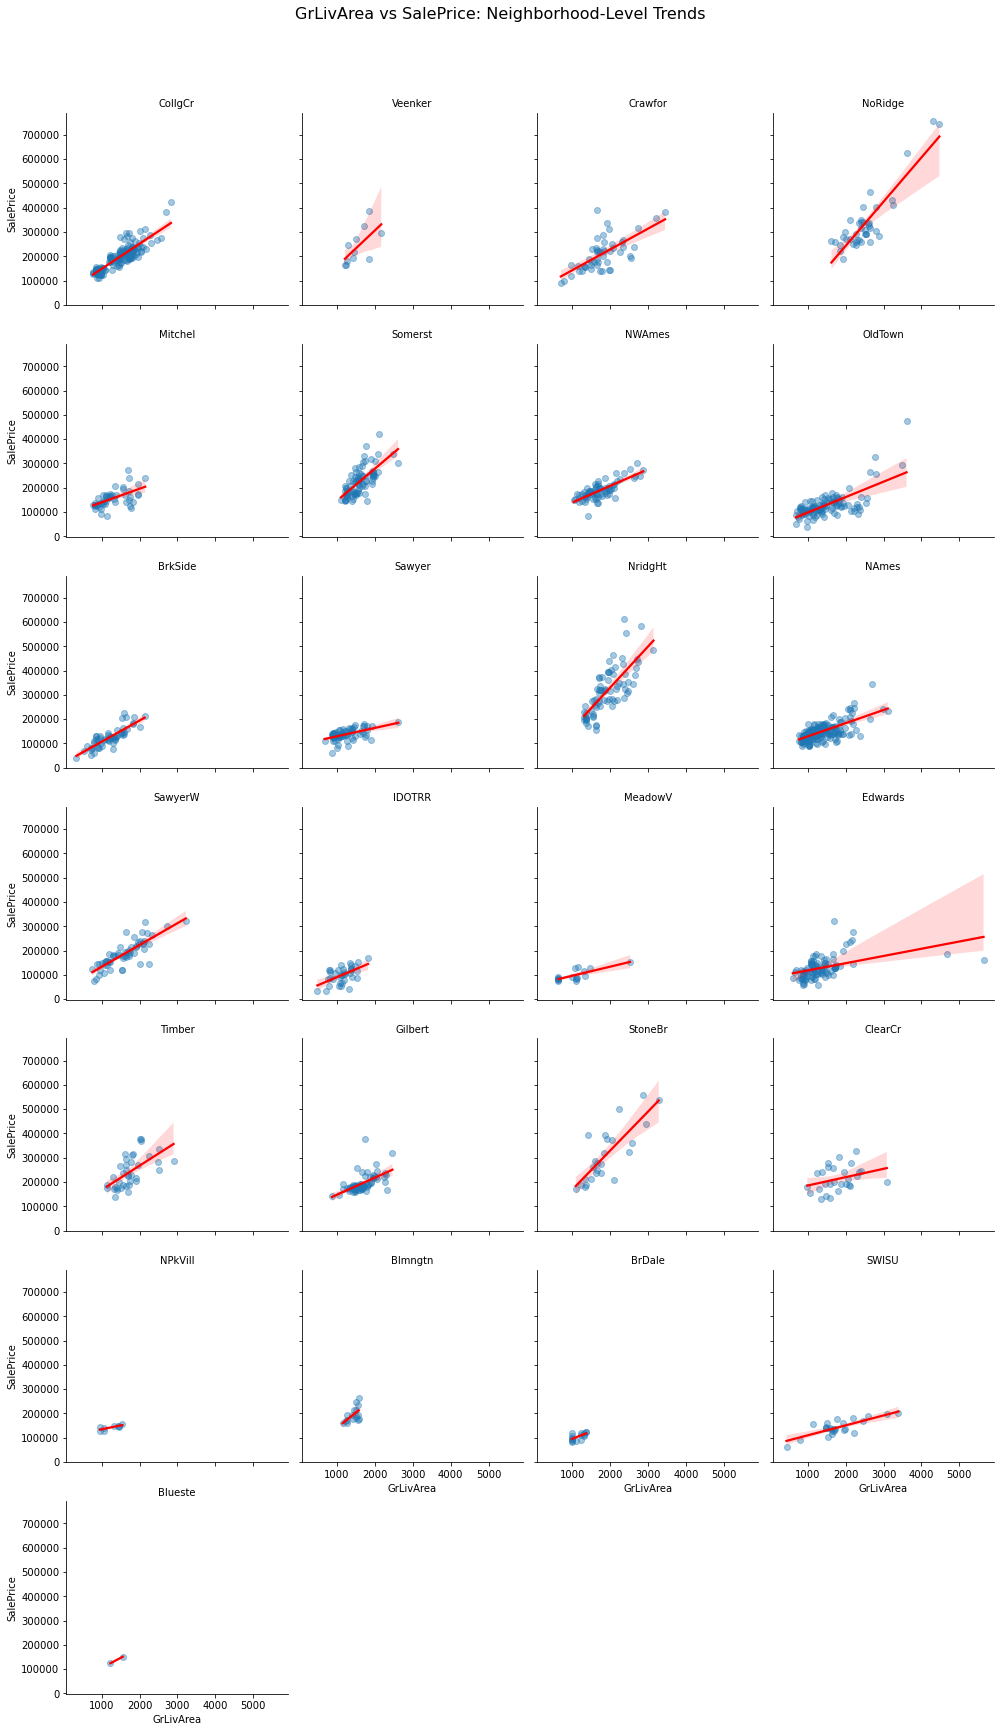

In [160]:
# Plot GrLivArea vs SalePrice, by neighborhood
g = sns.lmplot(
    data=df_train,
    x="GrLivArea",
    y="SalePrice",
    col="Neighborhood",
    col_wrap=4,
    height=3.5,
    scatter_kws={'alpha':0.4},
    line_kws={'color': 'red'}
)

g.set_titles(col_template="{col_name}")
g.fig.subplots_adjust(top=0.92)
g.fig.suptitle("GrLivArea vs SalePrice: Neighborhood-Level Trends", fontsize=16)
plt.show()

<h6 style="color: #ff5733;">GrLivArea and Neighborhood Findings:</h6>

We explored whether the relationship between GrLivArea (living space) and SalePrice varied across neighborhoods by including interaction terms in a regression model. However, *most of the interaction terms were not statistically significant.*

This suggests **multicollinearity**. In many areas, larger homes tend to cluster in higher-priced neighborhoods, making it difficult for the model to separate the effect of size from the effect of location. As a result, the overlap reduces the precision and usefulness of neighborhood-specific size interactions.

The two columns cannot be removed nor can be combined because they capture distinct, meaningful information and are conceptually different and can each independently influence SalePrice:
- GrLivArea measures physical living space — a quantitative property of the house.
- Neighborhood captures location-based desirability, which includes proximity to schools, amenities, safety, etc.

Combining these features could mask important local variation

<h5 style="color: blue;">Garage Cars and Neighborhood Analysis</h5>

1. Test Sale Price across neighbourhoods and garage sizes
2. Test for collinearity strength

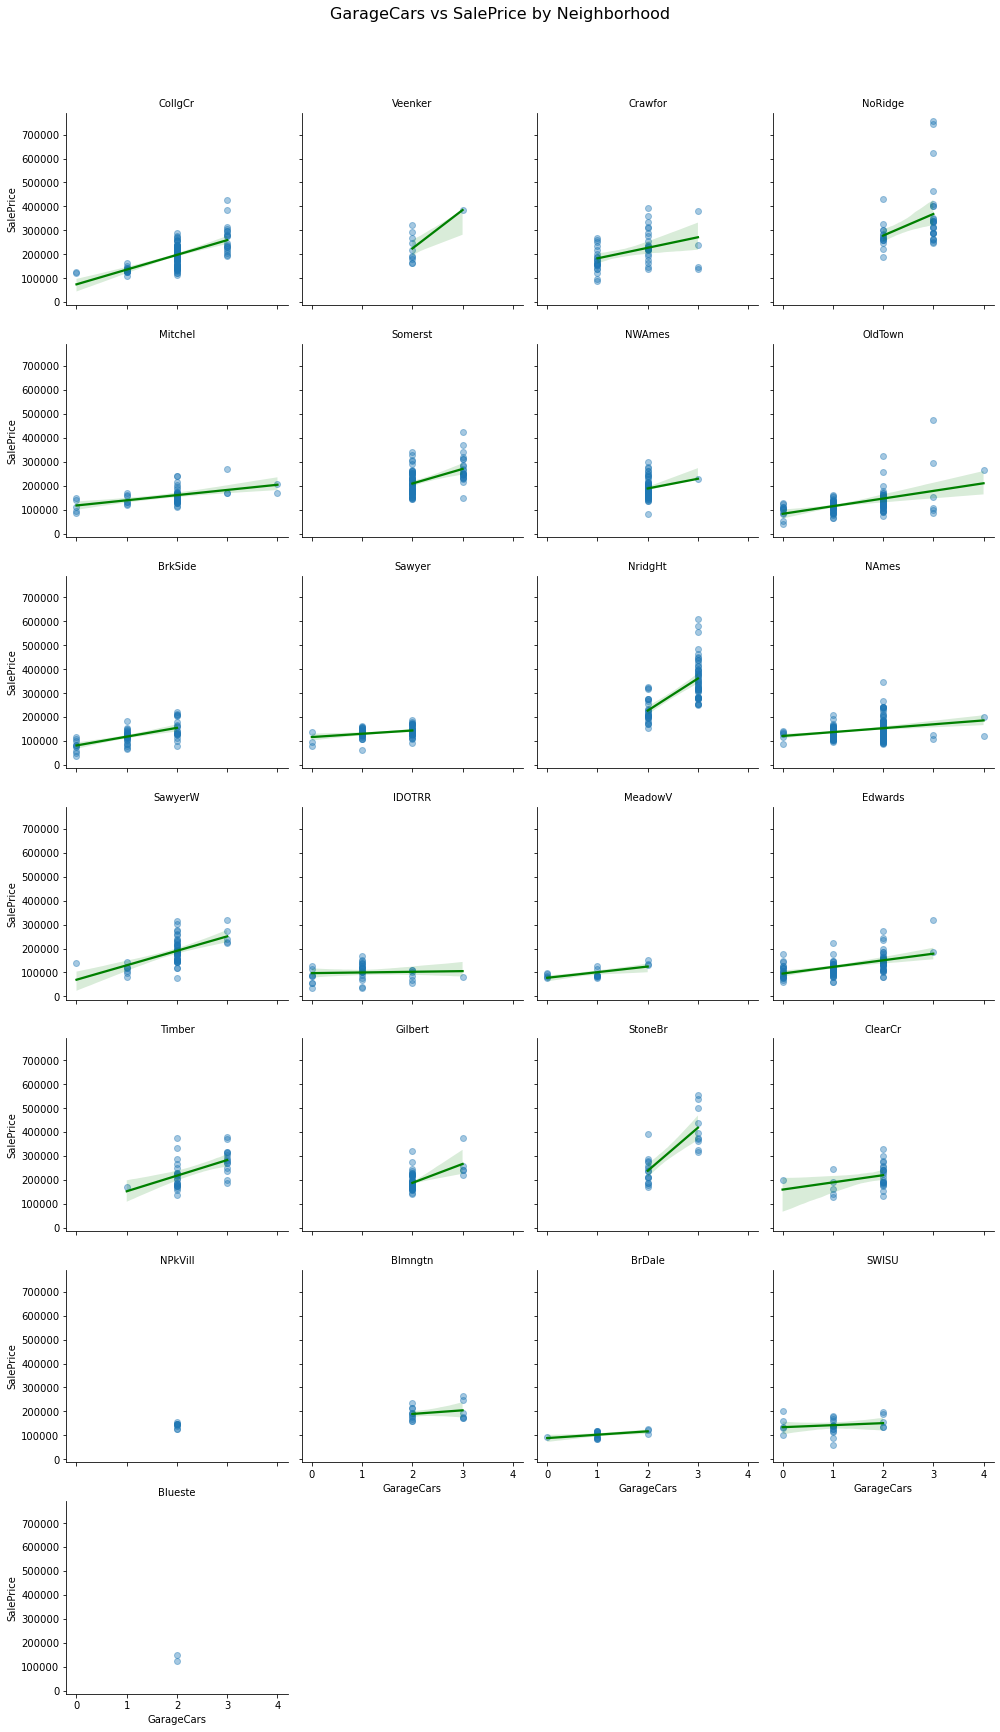

In [161]:
g = sns.lmplot(
    data=df_train,
    x="GarageCars",
    y="SalePrice",
    col="Neighborhood",
    col_wrap=4,
    height=3.5,
    scatter_kws={'alpha':0.4},
    line_kws={'color': 'green'}
)
g.set_titles(col_template="{col_name}")
g.fig.subplots_adjust(top=0.92)
g.fig.suptitle("GarageCars vs SalePrice by Neighborhood", fontsize=16)
plt.show()

<h6 style="color: #ff5733;">Garage Cars and Neighborhood Findings:</h6>

We examined how garage size and type vary by neighborhood. Higher-income areas like NoRidge and StoneBr tend to have larger garages, while neighborhoods like OldTown or IDOTRR show smaller, less finished garages.
Facet plots suggest that the price premium for garage area is stronger in upscale neighborhoods, while having less impact in others — highlighting another location-specific feature interaction.

<h5 style="color: blue;">Regression Testing</h5>

1. Test overall quality of the housee, neighbourhoods and living area
2. Test for strength of variables explaining Sale Price

In [162]:
# Model with main effects only
model_top = ols('SalePrice ~ OverallQual + GrLivArea + C(Neighborhood)', data=df_train).fit()
model_top.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.787
Model:                            OLS   Adj. R-squared:                  0.783
Method:                 Least Squares   F-statistic:                     203.5
Date:                Thu, 10 Apr 2025   Prob (F-statistic):               0.00
Time:                        20:25:41   Log-Likelihood:                -17416.
No. Observations:                1460   AIC:                         3.489e+04
Df Residuals:                    1433   BIC:                         3.503e+04
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                  -3.483e+04   1.15e+04     -3.018      0.003   -5.75e+04   -1.22e+04
C(Neighborhood)[T.Blueste] -3.075e+04   2.77e+04     -1.110      0.267   -8.51e+04    2.36e+04
C(Neighborhood)[T.BrDale]  -4.336e+04    1.3e+04     -3.341      0.001   -6.88e+04   -1.79e+04
C(Neighborhood)[T.BrkSide] -1.303e+04   1.05e+04     -1.246      0.213   -3.35e+04    7474.357
C(Neighborhood)[T.ClearCr]  2.458e+04   1.16e+04      2.124      0.034    1880.417    4.73e+04
C(Neighborhood)[T.CollgCr]  1.141e+04   9496.582      1.202      0.230   -7214.383       3e+04
C(Neighborhood)[T.Crawfor]  1.444e+04   1.05e+04      1.375      0.169   -6157.113     3.5e+04
C(Neighborhood)[T.Edwards] -1.784e+04   9985.734     -1.787      0.074   -3.74e+04    1745.272
C(Neighborhood)[T.Gilbert]  -892.8796   9954.350     -0.090      0.929   -2.04e+04    1.86e+04
C(Neighborhood)[T.IDOTRR]  -2.818e+04   1.11e+04     -2.531      0.011      -5e+04   -6335.193
C(Neighborhood)[T.MeadowV]  -1.91e+04    1.3e+04     -1.469      0.142   -4.46e+04    6400.778
C(Neighborhood)[T.Mitchel]  2030.6121   1.06e+04      0.192      0.847   -1.87e+04    2.27e+04
C(Neighborhood)[T.NAmes]   -4430.0994   9517.291     -0.465      0.642   -2.31e+04    1.42e+04
C(Neighborhood)[T.NPkVill] -1.781e+04   1.53e+04     -1.164      0.245   -4.78e+04    1.22e+04
C(Neighborhood)[T.NWAmes]  -4720.6584   1.01e+04     -0.468      0.640   -2.45e+04    1.51e+04
C(Neighborhood)[T.NoRidge]  6.464e+04   1.09e+04      5.909      0.000    4.32e+04    8.61e+04
C(Neighborhood)[T.NridgHt]  7.159e+04   9994.775      7.163      0.000     5.2e+04    9.12e+04
C(Neighborhood)[T.OldTown] -3.208e+04   9863.373     -3.253      0.001   -5.14e+04   -1.27e+04
C(Neighborhood)[T.SWISU]   -3.664e+04   1.19e+04     -3.073      0.002      -6e+04   -1.33e+04
C(Neighborhood)[T.Sawyer]  -1219.3805   1.02e+04     -0.119      0.905   -2.13e+04    1.88e+04
C(Neighborhood)[T.SawyerW]   303.0986   1.03e+04      0.030      0.976   -1.98e+04    2.04e+04
C(Neighborhood)[T.Somerst]  1.777e+04   9829.881      1.807      0.071   -1515.536     3.7e+04
C(Neighborhood)[T.StoneBr]  6.995e+04   1.17e+04      5.984      0.000     4.7e+04    9.29e+04
C(Neighborhood)[T.Timber]   2.991e+04   1.08e+04      2.762      0.006    8662.963    5.11e+04
C(Neighborhood)[T.Veenker]  4.711e+04   1.43e+04      3.285      0.001     1.9e+04    7.52e+04
OverallQual                 2.095e+04   1162.274     18.026      0.000    1.87e+04    2.32e+04
GrLivArea                     55.5645      2.499     22.237      0.000      50.663      60.466
==============================================================================
Omnibus:                      408.442   Durbin-Watson:                   1.949
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9010.

<h6 style="color: #ff5733;">Regression Testing Findings:</h6>

Built a model combining OverallQual, GrLivArea, and Neighborhood, as these are the top drivers of housing price.

All three variables were strong, independent predictors:

-	OverallQual captured finish and condition
-	GrLivArea measured usable space
-	Neighborhood reflected location-based pricing

This model uses clean, interpretable variables and avoids overfitting while capturing most of the variation in housing prices.

<h5 style="color: blue;">Re-assessing Features</h5>

1. Analysis of the strong features
2. Remove any other remaining outliers
3. Reassess correlation

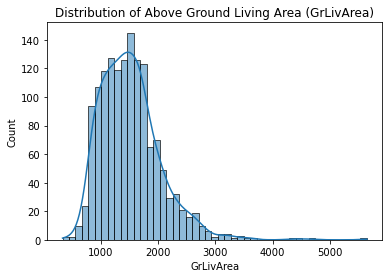

In [163]:
#Plotting distribution of living area
sns.histplot(df_train['GrLivArea'], kde=True)
plt.title("Distribution of Above Ground Living Area (GrLivArea)")
plt.show()

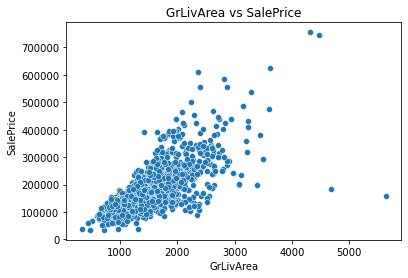

In [164]:
sns.scatterplot(x='GrLivArea', y='SalePrice', data=df_train)
plt.title("GrLivArea vs SalePrice")
plt.show()

/Users/rabab/opt/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


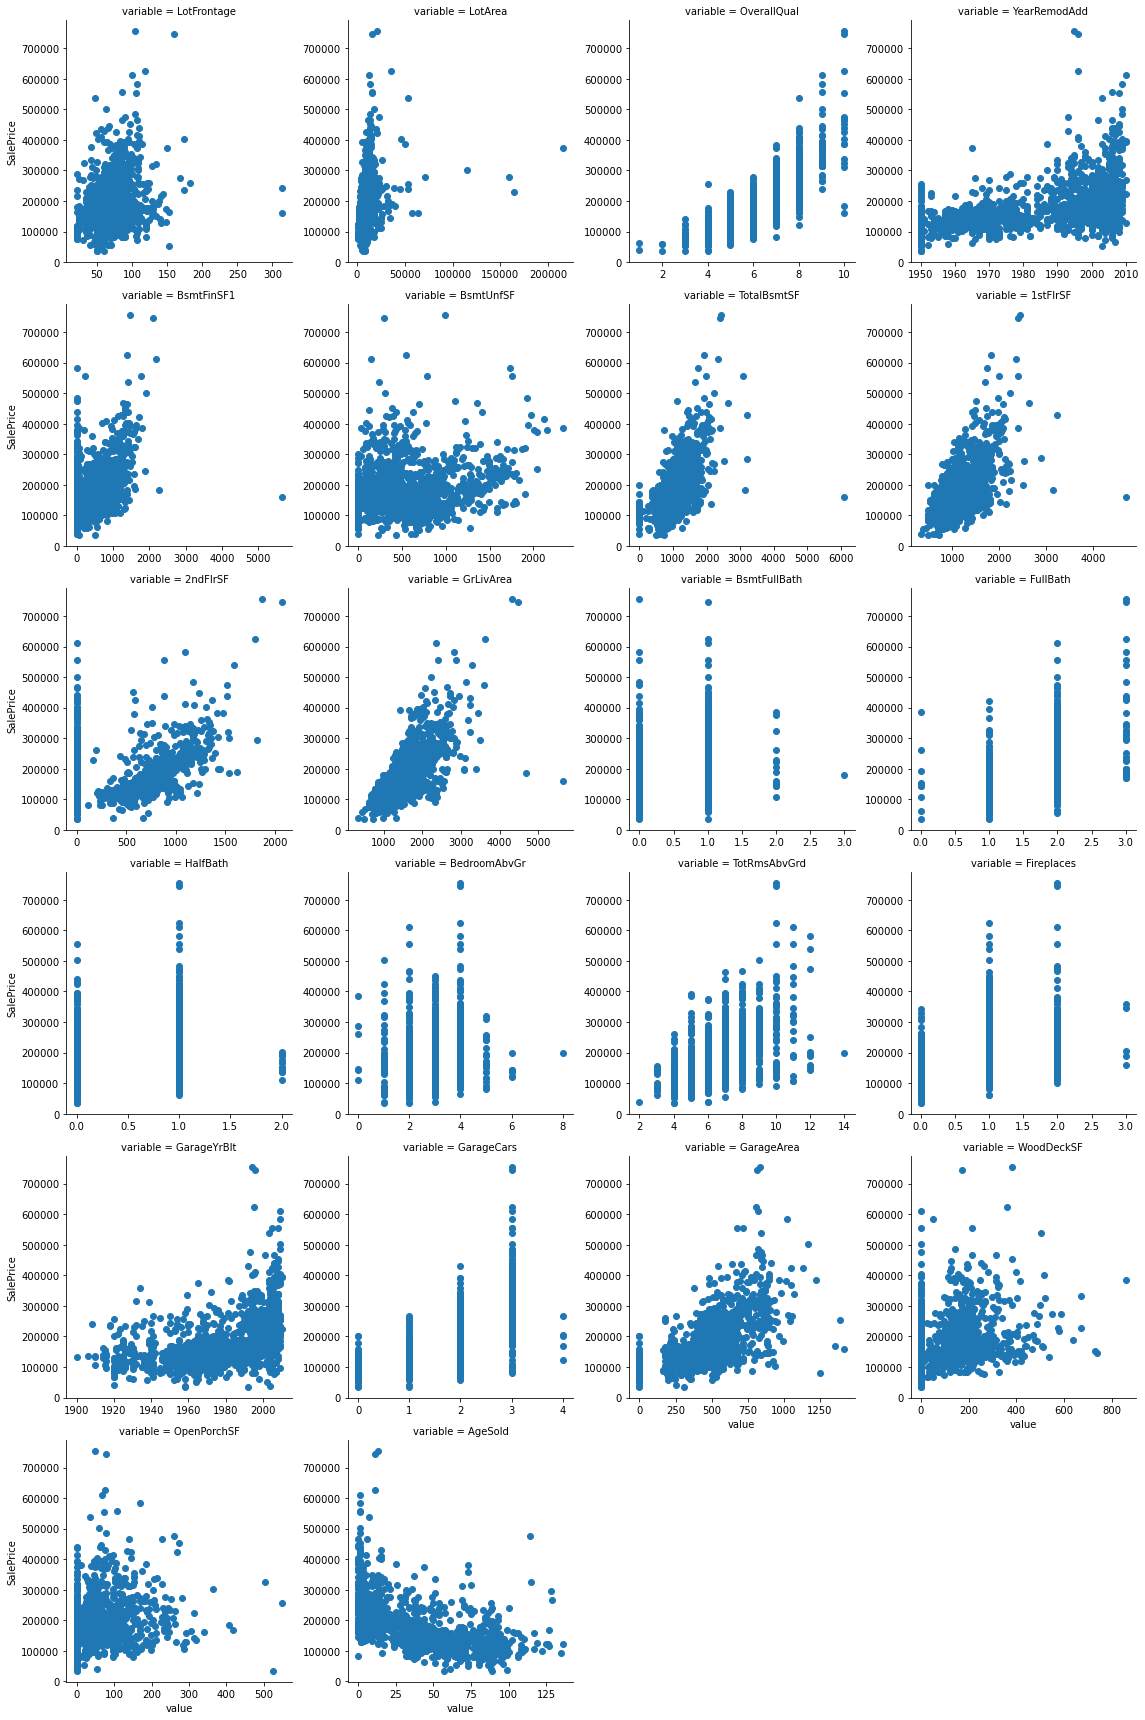

In [165]:
tr = df_train[df_train["SalePrice"].isnull() == False]
y = tr["SalePrice"]
tr = tr.select_dtypes(include=['float64', "int64"])
tr.drop("SalePrice", axis=1, inplace=True)

f = pd.melt(pd.concat([tr,y],axis=1) , id_vars = ['SalePrice'] , value_vars = tr.columns )
g = sns.FacetGrid(f, col = 'variable' , col_wrap = 4, size = 4,sharex=False , sharey=False)
g = g.map(plt.scatter, "value", "SalePrice")

In [166]:
df_train[['GrLivArea', 'SalePrice']].corr()

,GrLivArea,SalePrice
GrLivArea,1.000000,0.708624
SalePrice,0.708624,1.000000


GrLivArea shows a strong positive correlation (0.71) with SalePrice.


In [167]:
df_train = df_train.drop(df_train[(df_train["GrLivArea"] > 4000) & (df_train['SalePrice'] < 300000)].index)
df_train = df_train.drop(df_train[(df_train['TotalBsmtSF'] > 5000) & (df_train['SalePrice'] < 300000)].index)
df_train = df_train.drop(df_train[(df_train['BsmtFinSF1'] > 4000) & (df_train['SalePrice'] < 300000)].index)
df_train = df_train.drop(df_train[(df_train['LotFrontage'] > 250) & (df_train['SalePrice'] < 300000)].index)
df_train = df_train.drop(df_train[(df_train['OpenPorchSF'] > 400) & (df_train['SalePrice'] < 100000)].index)
df_train = df_train.drop(df_train[(df_train['1stFlrSF'] > 4000) & (df_train['SalePrice'] < 200000)].index)

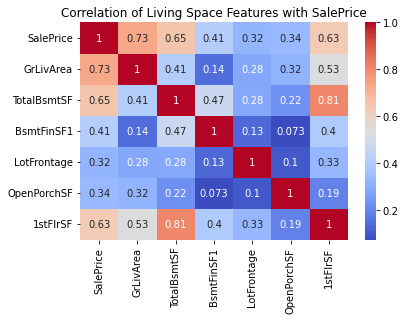

In [168]:
sns.heatmap(df_train[['SalePrice', 'GrLivArea', 'TotalBsmtSF', 'BsmtFinSF1','LotFrontage', 'OpenPorchSF','1stFlrSF' ]].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation of Living Space Features with SalePrice")
plt.show()

In [169]:
#Recategorize Total Rooms above ground to reduce excessive variance

def layout_tag(row):
    if row['TotRmsAbvGrd'] >= 9:
        return 'Many Rooms'
    elif row['TotRmsAbvGrd'] <= 5:
        return 'Few Rooms'
    else:
        return 'Typical Layout'

df_train['LayoutType'] = df_train.apply(layout_tag, axis=1)

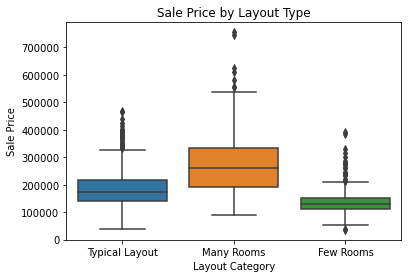

In [170]:
sns.boxplot(x='LayoutType', y='SalePrice', data=df_train)
plt.title('Sale Price by Layout Type')
plt.xlabel('Layout Category')
plt.ylabel('Sale Price')
plt.show()

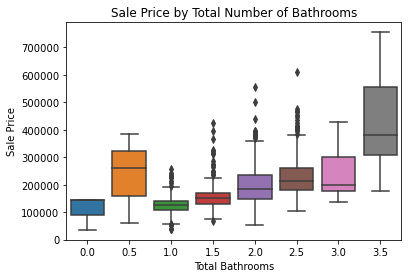

In [171]:
df_train['TotalBaths'] = df_train['FullBath'] + 0.5 * df_train['HalfBath']

#Dropping Full Bath and Half Bath because those are included in Total Baths columns
df_train = df_train.drop(columns = ['FullBath', 'HalfBath'])

sns.boxplot(x='TotalBaths', y='SalePrice', data=df_train)
plt.title("Sale Price by Total Number of Bathrooms")
plt.xlabel("Total Bathrooms")
plt.ylabel("Sale Price")
plt.show()

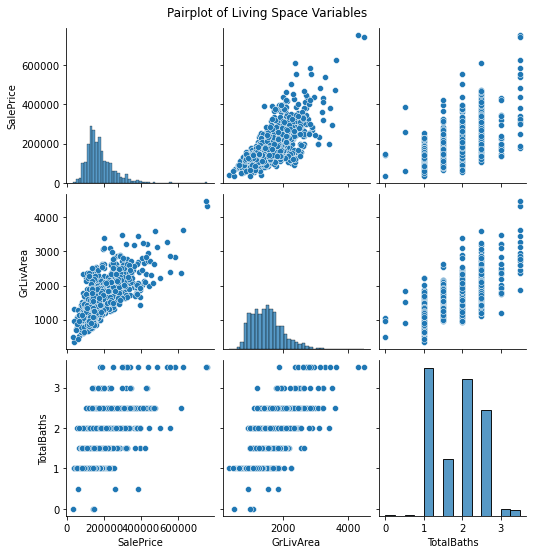

In [172]:
living_features = ['SalePrice', 'GrLivArea', 'TotalBaths']

sns.pairplot(df_train[living_features].dropna())
plt.suptitle("Pairplot of Living Space Variables", y=1.02)
plt.show()

<h6 style="color: #ff5733;">Reassessing Features Findings:</h6>


1. Outliers in for the following columns, where their values are unusually large but the sale price is low, removed:
| Column Removed     | Column Value Threshold       | Sale Price Threshold |
|--------------------|------------------------------|----------------------|
| GrLivArea          | > 4000                       | < 300,000            |
| TotalBsmtSF        | > 5000                       | < 300,000            |
| BsmtFinSF1         | > 4000                       | < 300,000            |
| LotFrontage        | > 250                        | < 300,000            |
| OpenPorchSF        | > 400                        | < 100,000            |
| 1stFlrSF           | > 4000                       | < 200,000            |

2. GrLivArea Distribution: Right-skewed, mostly clustered between 1000–2500 sqft  
3. Scatterplot GrLivArea vs SalePrice: Strong positive linear trend  
4. Correlation Heatmap:  
   - `TotalSqFt` has highest correlation with SalePrice: 0.82  
   - `GrLivArea`: 0.72  
   - `LivingAreaPerRoom`: 0.53  
5. `GrLivArea` and `TotalSqFt` both show strong positive linear relationships with `SalePrice`.
6. `LivingAreaPerRoom` and `AvgRoomSize` have more scattered relationships, indicating layout efficiency may play a secondary role compared to overall size.
7. `TotalBaths` shows a mild positive correlation with `SalePrice` but some variation, especially in homes with more than 3 baths.
8.`TotalSqFt` and `GrLivArea` are highly collinear, which is expected since they are structurally related.

This plot supports the idea that engineered features like `TotalSqFt` and `TotalBaths` contribute valuable signals to price prediction, while `AvgRoomSize` and `LivingAreaPerRoom` provide additional nuance about usability of space.

<h5 style="color: blue;">VIF Analysis</h5>

Collinearity analysis on numerical columns

In [173]:
#Getting VIF scores to test for collinearity
X = df_train.select_dtypes(include=['float64', 'int64']).copy()
X = X.dropna()
X = sm.add_constant(X)

vif_df = pd.DataFrame()
vif_df["feature"] = X.columns
vif_df["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_df)

         feature           VIF
0          const  29426.072057
1    LotFrontage      1.258277
2        LotArea      1.225980
3    OverallQual      3.532202
4   YearRemodAdd      1.957986
5     BsmtFinSF1      8.373307
6      BsmtUnfSF      8.683456
7    TotalBsmtSF     10.284286
8       1stFlrSF     67.499913
9       2ndFlrSF     90.692739
10     GrLivArea    119.369788
11  BsmtFullBath      1.995911
12  BedroomAbvGr      2.330657
13  TotRmsAbvGrd      4.405548
14    Fireplaces      1.507620
15   GarageYrBlt      3.015582
16    GarageCars      5.593306
17    GarageArea      5.355210
18    WoodDeckSF      1.175437
19   OpenPorchSF      1.186787
20     SalePrice      6.815477
21       AgeSold      3.688603
22    TotalBaths      3.692487


/Users/rabab/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<h6 style="color: #ff5733;">VIF Analysis Findings:</h6>


| Collinearity Level     | Feature(s)                                                                                                                                   |
|:----|:----|
| ✅ Low (<5)            | LotFrontage<br>LotArea<br>YearRemodAdd<br>BsmtFullBath<br>BedroomAbvGr<br>Fireplaces<br>GarageYrBlt<br>WoodDeckSF<br>OpenPorchSF           |
| 🟧 Moderate (5–10)     | BsmtFinSF1<br>BsmtUnfSF<br>GarageCars<br>GarageArea<br>SalePrice<br>OverallQual<br>TotRmsAbvGrd<br>AgeSold<br>TotalBaths                   |
| 🟥 High (= ∞)          | TotalBsmtSF<br>1stFlrSF<br>2ndFlrSF<br>GrLivArea<br>Total_sqft                                                                               |

**Conclusion:** 
1. Most featurees have moderate to low collinearity. Therefor these can ve kept as is. 

2. Features like 1stFlrSF, 2ndFlrSF, and GrLivArea have high collineaerity but are independently meaningful to stakeholders, therefor must be included in the model. Removing them may reduce model transparency. While PCA would remove collinearity, it would destroy interpretability by combining these features into principal components.


In [174]:
#Combining total square footage of the house
total_sqft_columns = ['TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea']
df_train['Total_sqft'] = df_train[total_sqft_columns].sum(axis=1)
df_total_sqft = df_train[total_sqft_columns].copy()
df_train['Total_sqft'].head(10)

Id
1     4276
2     3786
3     4492
4     4190
5     5541
6     3520
7     5074
8     5287
9     4500
10    3145
Name: Total_sqft, dtype: int64

### Predictive Modelling
1. Multiple Lineaer Regression
2. Heteroskedascity analysis
3. Hypothesis Testing
4. MAE and RMSE analysis

In [175]:
df_train.head()

,MSZoning,LotFrontage,LotArea,Neighborhood,BldgType,HouseStyle,OverallQual,YearRemodAdd,Exterior1st,Exterior2nd,...,GarageFinish,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,SalePrice,AgeSold,LayoutType,TotalBaths,Total_sqft
Id,,,,,,,,,,,,,,,,,,,,,
1,RL,65.0,8450,CollgCr,1Fam,2Story,7,2003,VinylSd,VinylSd,...,RFn,2,548,0,61,208500,5,Typical Layout,2.5,4276
2,RL,80.0,9600,Veenker,1Fam,1Story,6,1976,MetalSd,MetalSd,...,RFn,2,460,298,0,181500,31,Typical Layout,2.0,3786
3,RL,68.0,11250,CollgCr,1Fam,2Story,7,2002,VinylSd,VinylSd,...,RFn,2,608,0,42,223500,7,Typical Layout,2.5,4492
4,RL,60.0,9550,Crawfor,1Fam,2Story,7,1970,Wd Sdng,Wd Shng,...,Unf,3,642,0,35,140000,91,Typical Layout,1.0,4190
5,RL,84.0,14260,NoRidge,1Fam,2Story,8,2000,VinylSd,VinylSd,...,RFn,3,836,192,84,250000,8,Many Rooms,2.5,5541


In [176]:
print(f"df_train: {df_train.shape}")

df_train: (1456, 41)


In [190]:
# Target and features
#y = np.log1p(df_train["SalePrice"])
y = df_train['SalePrice']
X = df_train.drop(columns=["SalePrice"])
X = pd.get_dummies(X, drop_first=True)

#Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [191]:
# Fit linear regression model
reg = linear_model.LinearRegression()
reg.fit(X_train, y_train)

LinearRegression()

In [192]:
#Build the model equation
equation = ""
for coef, feat in zip(reg.coef_, X_train):
    equation += f"({coef:.3f} x {feat}) + \n"

print(f"""The linear regression model is:  \n
    Sales Price = {equation}({reg.intercept_:3f})""")

The linear regression model is:  

    Sales Price = (-17.460 x LotFrontage) + 
(0.497 x LotArea) + 
(7868.041 x OverallQual) + 
(198.141 x YearRemodAdd) + 
(15.179 x BsmtFinSF1) + 
(-6.843 x BsmtUnfSF) + 
(10.878 x TotalBsmtSF) + 
(-16.506 x 1stFlrSF) + 
(12.658 x 2ndFlrSF) + 
(15.298 x GrLivArea) + 
(-2167.450 x BsmtFullBath) + 
(-7879.876 x BedroomAbvGr) + 
(1744.042 x TotRmsAbvGrd) + 
(1685.794 x Fireplaces) + 
(18.579 x GarageYrBlt) + 
(7233.443 x GarageCars) + 
(3.964 x GarageArea) + 
(10.464 x WoodDeckSF) + 
(40.462 x OpenPorchSF) + 
(-213.813 x AgeSold) + 
(-102.885 x TotalBaths) + 
(22.327 x Total_sqft) + 
(47683.208 x MSZoning_FV) + 
(33606.650 x MSZoning_RH) + 
(31953.241 x MSZoning_RL) + 
(26548.419 x MSZoning_RM) + 
(-0.000 x Neighborhood_Blueste) + 
(9955.608 x Neighborhood_BrDale) + 
(-5941.830 x Neighborhood_BrkSide) + 
(-33009.450 x Neighborhood_ClearCr) + 
(-14713.222 x Neighborhood_CollgCr) + 
(7483.454 x Neighborhood_Crawfor) + 
(-21107.157 x Neighborhood_Edwards) +

In [193]:
#Calcute model statistics
n = X_train.shape[0]  # number of samples
p = X_train.shape[1]  # number of features

y_pred    = reg.predict(X_test)
residuals = y_test - y_pred

# R-squared
r_squared = reg.score(X_test, y_test)

# Adjusted R-squared
adjusted_r_squared = 1 - (1 - r_squared) * (n - 1) / (n - p - 1)

# Standard error
std_err = np.sqrt(np.sum(residuals**2) / (n - p - 1))

print(f"""
Regression Summary:
\n
R-squared: {r_squared:.4f}
Adjusted R-squared: {adjusted_r_squared:.4f}
Standard Error: {std_err:.4f}
""")


Regression Summary:


R-squared: 0.8883
Adjusted R-squared: 0.8683
Standard Error: 23203.1389



<h6 style="color: #ff5733;">Model Findings:</h6>
The model has a high R-squared value (0.8883) calculated on the test data, therefore implying it is an accurate predictor of house prices

<h5 style="color: blue;">Test: Heteroskedasticity</h5>

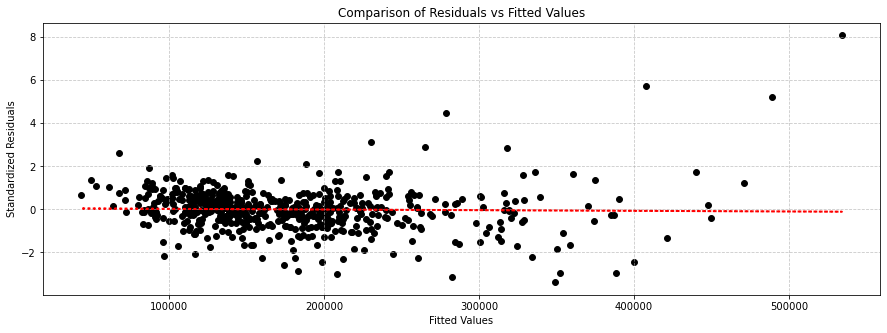

In [194]:
#Plot to check for heteroskedasticity
residuals_array = np.array(residuals).reshape(-1, 1)

scaler          = StandardScaler().fit(residuals_array)
norm_residuals  = scaler.transform(residuals_array)


plt.figure(figsize=(15,5))
plt.grid(True, linestyle='--', alpha=0.7)
plt.title(f"Comparison of Residuals vs Fitted Values")

plt.scatter(y_pred, norm_residuals, c='black', s=35)
plt.xlabel("Fitted Values")
plt.ylabel("Standardized Residuals")


# add trend line  
lin_reg = linear_model.LinearRegression()
lin_reg.fit(y_pred.reshape(-1, 1), norm_residuals)  # Fit to the fitted values
trendline = lin_reg.predict(y_pred.reshape(-1, 1))

# Plot the trendline
plt.plot(y_pred, trendline, color='red', linewidth=2, linestyle='dotted')

/Users/rabab/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


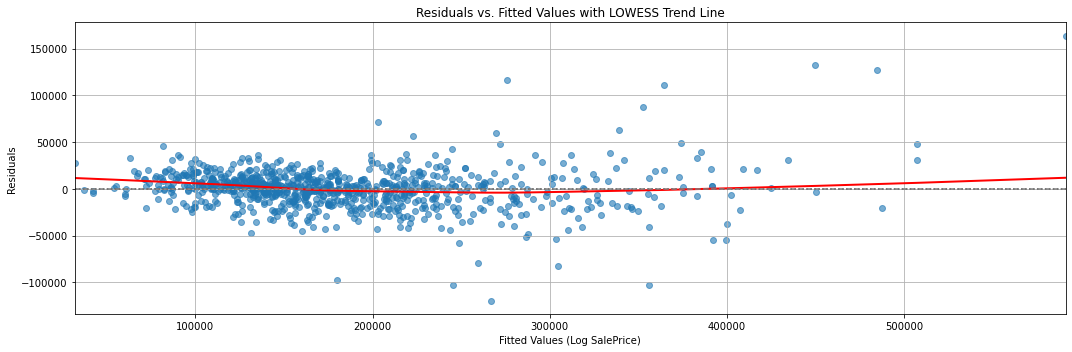

In [195]:
#Testing on ols() model

#Fitting to ols model
X_train_sm = sm.add_constant(X_train)
ols_model = sm.OLS(y_train, X_train_sm).fit()

# Residuals vs. Fitted Values with LOWESS trend line
fitted_vals = ols_model.fittedvalues
residuals = ols_model.resid

plt.figure(figsize=(15, 5))
sns.residplot(x=fitted_vals, y=residuals, lowess=True, 
              line_kws={'color': 'red', 'lw': 2}, 
              scatter_kws={'alpha': 0.6})
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel("Fitted Values (Log SalePrice)")
plt.ylabel("Residuals")
plt.title("Residuals vs. Fitted Values with LOWESS Trend Line")
plt.grid(True)
plt.tight_layout()
plt.show()

In [196]:
# Breusch-Pagan test for heteroskedasticity
bp       = het_breuschpagan(residuals, X_train)
measures = ('LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value')

for measure, value in zip(measures, bp):
    print(f"{measure}: {value}")

LM Statistic: 292.5938966506759
LM-Test p-value: 2.297090561122374e-14
F-Statistic: 3.0166496655598687
F-Test p-value: 2.6115242320960756e-20


<h6 style="color: #ff5733;">Heteroskedasticity Findings:</h6>

1. The model is homoskedastic as the residuals equally distributed across the trendline throughout the test dataset. 
2. Testing against LOWESS line, we see the residuals are still centered around 0, there is noticeable spread and slight non-linearity in the LOWESS line. This suggests the model might be missing some underlying structure in the data or that some non-linear relationships remain unmodeled. The model shows signs of minor misspecification. There’s some mild heteroscedasticity and a non-linear trend in the residuals, implying that additional features or transformations (e.g., polynomial terms or interaction effects) may improve the model fit.
3. This implies that the prediction error does not grow larger as house prices increase.

| Measure | Value | Conclusion |
| :--- | :--- | :--- |
| LM-Test p-value| 2.29 x 10^-14 | Lower than 0.05, confirms there is no heteroskedasticity |
| F-Test p-value | 2.29 x 10^-20 | Lower than 0.05, confirms there is no heteroskedasticity |

**Conclusion:** The model can predict homes more accurately without running into errors at higher numbers

<h5 style="color: blue;">Test: Normal Q-Q</h5>

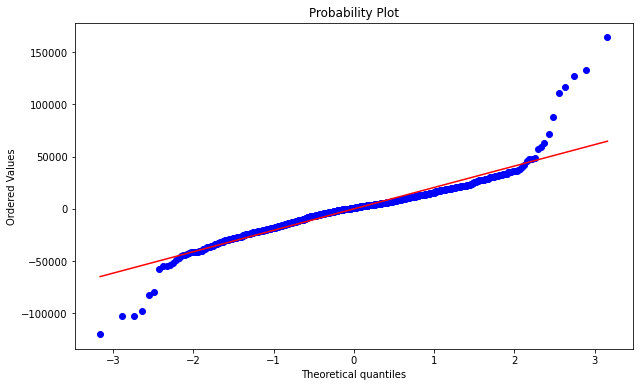

In [197]:
#Creat Q-Q plot
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

stats.probplot(residuals, dist = 'norm', plot = ax)
plt.show()


ax.set_title("Normal Q-Q Plot of Residuals")
ax.set_xlabel("Theoretical Quantiles")
ax.set_label("Ordered Values")

<h6 style="color: #ff5733;">Normal Q-Q Findings:</h6>

1. The residuals mostly follow the red line closely, especially in the middle of the distribution (around theoretical quantiles -2 to 2). This suggests that the central part of our distribution aligns with a normal distribution.

2. The deviation at the lower tail (below -2) implies that the lower end of the data has smaller values than expected
3. The deviation at the upper tail (below 2) implies that the higher end of the data has larger values than expected

**Conclusion:** The model predictions aren't entirely normally distributed and outliers 

<h5 style="color: blue;">Test: MAE & RMSE</h5>

In [198]:
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"""
MAE: {mae:.2f} 
RMSE: {rmse:.2f}
""")


MAE: 17553.31 
RMSE: 26141.37



In [199]:
mean_price = y.mean() 
mae_percent = (mae / mean_price) * 100
rmse_percent = (rmse / mean_price) * 100

print(f"""
MAE is {mae_percent:.1f}% of mean 
RMSE is {rmse_percent:.1f}% of mean
""")


MAE is 9.7% of mean 
RMSE is 14.4% of mean



<h6 style="color: #ff5733;">MAE & RMSE Findings:</h6>

1. The error in the model is **$17,553**. The relative error is 9.7% of the mean (this is an acceptable error in the grand scheme things as house prices are in the range of hundreds of thousands of dollars). 

2. The larger errors in the model are close **$26,141**. This is 14.4% of the mean sale price. Larger errors could be due to several factors, such as:

- Unpredictable outliers or rare cases (e.g., very expensive properties or unusual market conditions)

- Incomplete or incorrect features in the model that didn't capture certain nuances of the property values.

- Issues like extreme property conditions, unique amenities, or incorrect data points for certain houses.

**Conclusion:** The model is great for house price prediction

### Appendix

In [200]:
#Training flattened - with the model
df1 = pd.concat([X_train, y_train.rename('SalePrice')], axis=1)

path1 = "model_train_data.csv"

df1.to_csv(path1, index=False)

In [201]:
#Testing flattened - with the model
df2 = pd.concat([X_test, y_test.rename('SalePrice')], axis=1)
df2['Predicted_SalePrice'] = y_pred

path2 = "model_test_data.csv"

df2.to_csv(path2, index=False)

In [202]:
#Cleaned unflattened model
path3 = "cleaned_training_data.csv"
df_train.to_csv(path3, index=False)